In [1]:
import json
from networkx.readwrite import json_graph

def read_graph_from_json(json_file):
    with open(json_file) as f:
        data = json.load(f)
    return json_graph.adjacency_graph(data) 

In [2]:
# Read Oklahoma county graph from the json file "OK_county.json"
filepath = 'districting-data/'
filename = 'OK_county.json'

G = read_graph_from_json( filepath + filename )

In [3]:
# For each node, print the node #, county name, and its population
for node in G.nodes:
    county_name = G.nodes[node]['NAME20']
    county_population = G.nodes[node]['P0010001']
    G.nodes[node]['TOTPOP'] = county_population
    print("Node",node,"represents",county_name,"County, which had a population of",county_population,"in the 2020 census.")

Node 0 represents Washita County, which had a population of 10924 in the 2020 census.
Node 1 represents Jackson County, which had a population of 24785 in the 2020 census.
Node 2 represents Major County, which had a population of 7782 in the 2020 census.
Node 3 represents Delaware County, which had a population of 40397 in the 2020 census.
Node 4 represents Custer County, which had a population of 28513 in the 2020 census.
Node 5 represents Ellis County, which had a population of 3749 in the 2020 census.
Node 6 represents Oklahoma County, which had a population of 796292 in the 2020 census.
Node 7 represents Johnston County, which had a population of 10272 in the 2020 census.
Node 8 represents Comanche County, which had a population of 121125 in the 2020 census.
Node 9 represents Pushmataha County, which had a population of 10812 in the 2020 census.
Node 10 represents Cleveland County, which had a population of 295528 in the 2020 census.
Node 11 represents Wagoner County, which had a p

In [4]:
# Let's impose a 2% population deviation (+/-1%)
# (Usually, we use 1% deviation, but this instance is infeasible at 1%.)
deviation = 0.02

k = 5  # desired number of districts
total_population = sum( G.nodes[i]['TOTPOP'] for i in G.nodes )
ideal_population = total_population / k

import math
L = math.ceil( ( 1 - deviation / 2 ) * ideal_population )
U = math.floor( ( 1 + deviation / 2 ) * ideal_population )
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 783952 and U = 799789 and k = 5


In [5]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

# create variables
x = m.addVars( G.nodes, k, vtype=GRB.BINARY ) # x[i,j] = 1 if county i is assigned to district j
y = m.addVars( G.edges, vtype=GRB.BINARY )    # y[u,v] = 1 when edge {u,v} is cut

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-03


In [6]:
# objective is to minimize cut edges
m.setObjective( gp.quicksum( y[u,v] for u,v in G.edges ), GRB.MINIMIZE )

## Equivalently, we could write:
#m.setObjective( gp.quicksum( y ), GRB.MINIMIZE )

In [7]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum( x[i,j] for j in range(k) ) == 1 for i in G.nodes )

# add constraints saying that each district has a population at least L and at most U.
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) <= U for j in range(k) )

# add constraints saying that edge {u,v} is cut if u is assigned to district j but v is not.
m.addConstrs( x[u,j] - x[v,j] <= y[u,v] for u,v in G.edges for j in range(k) )

m.update()

In [8]:
# solve IP model
m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: AMD Ryzen Threadripper 3990X 64-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads

Optimize a model with 1062 rows, 580 columns and 4080 nonzeros
Model fingerprint: 0xef531b25
Variable types: 0 continuous, 580 integer (580 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+05]
Presolve time: 0.01s
Presolved: 1062 rows, 580 columns, 4080 nonzeros
Variable types: 0 continuous, 580 integer (580 binary)
Found heuristic solution: objective 117.0000000

Root relaxation: objective 0.000000e+00, 649 iterations, 0.04 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0  385  117.00000  

In [9]:
print("The number of cut edges is",m.objval)

# retrieve the districts and their populations
districts = [ [ i for i in G.nodes if x[i,j].x > 0.5 ] for j in range(k) ]
district_county_names = [ [ G.nodes[i]['NAME20'] for i in district ] for district in districts ]
district_populations = [ sum( G.nodes[i]['TOTPOP'] for i in district ) for district in districts ]

# print district info
for j in range(k):
    print("District",j,"has these nodes =",districts[j],"and this population =",district_populations[j] )
    print("The corresponding county names are =",district_county_names[j] )
    print("")

The number of cut edges is 37.0
District 0 has these nodes = [0, 1, 2, 4, 5, 8, 12, 16, 17, 18, 21, 25, 26, 28, 31, 32, 36, 37, 42, 43, 44, 49, 50, 51, 56, 60, 67, 68, 69, 70, 72, 74, 76] and this population = 787751
The corresponding county names are = ['Washita', 'Jackson', 'Major', 'Custer', 'Ellis', 'Comanche', 'Beckham', 'Osage', 'Tillman', 'Logan', 'Pawnee', 'Beaver', 'Dewey', 'Roger Mills', 'Texas', 'Woodward', 'Kingfisher', 'Grant', 'Payne', 'Cimarron', 'Garfield', 'Harper', 'Alfalfa', 'Lincoln', 'Caddo', 'Greer', 'Woods', 'Harmon', 'Kay', 'Blaine', 'Creek', 'Kiowa', 'Noble']

District 1 has these nodes = [6] and this population = 796292
The corresponding county names are = ['Oklahoma']

District 2 has these nodes = [7, 9, 13, 19, 20, 22, 23, 24, 27, 29, 30, 33, 35, 38, 40, 41, 46, 48, 52, 53, 58, 59, 61, 62, 63, 66, 71, 73, 75] and this population = 790988
The corresponding county names are = ['Johnston', 'Pushmataha', 'Garvin', 'Pittsburg', 'Jefferson', 'Okfuskee', 'McClain',

In [10]:
import networkx as nx
for district in districts:
    print("Is district =", district, "connected?", nx.is_connected( G.subgraph( district ) ) )

Is district = [0, 1, 2, 4, 5, 8, 12, 16, 17, 18, 21, 25, 26, 28, 31, 32, 36, 37, 42, 43, 44, 49, 50, 51, 56, 60, 67, 68, 69, 70, 72, 74, 76] connected? True
Is district = [6] connected? True
Is district = [7, 9, 13, 19, 20, 22, 23, 24, 27, 29, 30, 33, 35, 38, 40, 41, 46, 48, 52, 53, 58, 59, 61, 62, 63, 66, 71, 73, 75] connected? True
Is district = [11, 34, 64] connected? True
Is district = [3, 10, 14, 15, 39, 45, 47, 54, 55, 57, 65] connected? False


In [11]:
# Let's draw it on a map
import geopandas as gpd

In [12]:
# Read Oklahoma county shapefile from "OK_county.shp"
filepath = 'districting-data/'
filename = 'OK_county.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename )

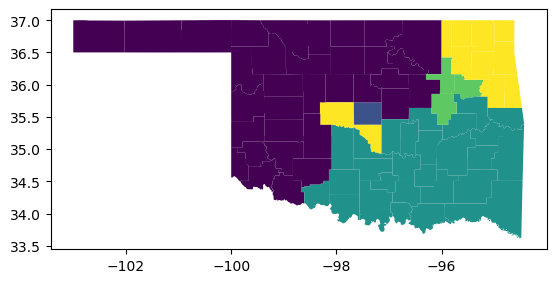

In [13]:
# Which district is each county assigned to?
assignment = [ -1 for i in G.nodes ]
labeling = { i : j for i in G.nodes for j in range(k) if x[i,j].x > 0.5 }

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()